# Pose Detection with DensePose

This notebook uses an open source project [facebookresearch/DensePose](https://github.com/facebookresearch/DensePose) to detect multi person poses on a test image.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install DensePose

Installing the DensePose seems to be very tricky. For more information, see [http://linkinpark213.com/2018/11/18/densepose-minesweeping/](http://linkinpark213.com/2018/11/18/densepose-minesweeping/).

First, we are going to install an Anaconda with some fixed dependencies:

In [1]:
import os
from os.path import exists, join, basename, splitext

# install Anaconda Python 2.7 to control the dependencies
# see for more info: 
if not exists('anaconda2'):
  !wget -q https://repo.anaconda.com/archive/Anaconda2-2019.03-Linux-x86_64.sh
  !chmod +x Anaconda2-2019.03-Linux-x86_64.sh
  !bash ./Anaconda2-2019.03-Linux-x86_64.sh -b -f -p /content/anaconda2
  # set PATH environment variable
  os.environ['PATH'] = "/content/anaconda2/bin:" + os.environ['PATH']
  # install PyTorch
  !conda install -y pyyaml=3.12
  !conda install -y mkl-include
  !conda install -y pytorch=1.0.1 torchvision cudatoolkit=10.0 -c pytorch
  !ln -s /content/anaconda2/lib/python2.7/site-packages/torch/lib/ /content/anaconda2/lib/python2.7/site-packages/
  # install GCC 4.9
  !conda install -y -c serge-sans-paille gcc_49
  !ln -fs /content/anaconda2/lib/libmpfr.so /content/anaconda2/lib/libmpfr.so.4
  os.environ['CC'] = '/content/anaconda2/bin/gcc-4.9'
  os.environ['CXX'] = '/content/anaconda2/bin/g++-4.9'
  # protobuf 3.5
  #!apt-get -qq remove -y protobuf-compiler
  !conda install -y protobuf=3.5
  # pycocotools
  !conda install -y -c conda-forge pycocotools
  
# we need some headers from the pytorch source
if not exists('pytorch'):
  !git clone -q --depth 1 --recursive -b v1.0.1 https://github.com/pytorch/pytorch

PREFIX=/content/anaconda2
installing: python-2.7.16-h9bab390_0 ...
using -f (force) option
Python 2.7.16 :: Anaconda, Inc.
installing: conda-env-2.6.0-1 ...
using -f (force) option
installing: blas-1.0-mkl ...
using -f (force) option
installing: ca-certificates-2019.1.23-0 ...
using -f (force) option
installing: intel-openmp-2019.3-199 ...
using -f (force) option
installing: libgcc-ng-8.2.0-hdf63c60_1 ...
using -f (force) option
installing: libgfortran-ng-7.3.0-hdf63c60_0 ...
using -f (force) option
installing: libstdcxx-ng-8.2.0-hdf63c60_1 ...
using -f (force) option
installing: bzip2-1.0.6-h14c3975_5 ...
using -f (force) option
installing: expat-2.2.6-he6710b0_0 ...
using -f (force) option
installing: fribidi-1.0.5-h7b6447c_0 ...
using -f (force) option
installing: gmp-6.1.2-h6c8ec71_1 ...
using -f (force) option
installing: graphite2-1.3.13-h23475e2_0 ...
using -f (force) option
installing: icu-58.2-h9c2bf20_1 ...
using -f (force) option
installing: jbig-2.1-hdba287a_0 ...
using -f 

Check whether the system dependencies are installed correctly:

In [2]:
# some sanity checks
!conda --version
!protoc --version
!gcc-4.9 --version

conda 4.8.3
libprotoc 3.5.1
gcc-4.9 (GCC) 4.9.1
Copyright (C) 2014 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



Clone the DensePose project and build it:

In [3]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/facebookresearch/DensePose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone project
  !git clone -q --depth 1 $git_repo_url
  # install dependencies
  !cd $project_name && pip install -q -r requirements.txt
  # update CMakeLists.txt
  cmakelists_txt_content = """
cmake_minimum_required(VERSION 2.8.12 FATAL_ERROR)
set(Caffe2_DIR "/content/anaconda2/lib/python2.7/site-packages/torch/share/cmake/Caffe2/")
find_package(Caffe2 REQUIRED)

include_directories("/content/anaconda2/lib/python2.7/site-packages/torch/lib/include")
include_directories("/content/anaconda2/include")
include_directories("/content/pytorch")

add_library(libprotobuf STATIC IMPORTED)
set(PROTOBUF_LIB "/content/anaconda2/lib/libprotobuf.a")
set_property(TARGET libprotobuf PROPERTY IMPORTED_LOCATION "${PROTOBUF_LIB}")

if (${CAFFE2_VERSION} VERSION_LESS 0.8.2)
  # Pre-0.8.2 caffe2 does not have proper interface libraries set up, so we
  # will rely on the old path.
  message(WARNING
      "You are using an older version of Caffe2 (version " ${CAFFE2_VERSION}
      "). Please consider moving to a newer version.")
  include(cmake/legacy/legacymake.cmake)
  return()
endif()

# Add compiler flags.
set(CMAKE_C_FLAGS "${CMAKE_C_FLAGS} -std=c11")
set(CMAKE_CXX_FLAGS "${CMAKE_CXX_FLAGS} -std=c++11 -O2 -fPIC -Wno-narrowing")

# Print configuration summary.
include(cmake/Summary.cmake)
detectron_print_config_summary()

# Collect custom ops sources.
file(GLOB CUSTOM_OPS_CPU_SRCS ${CMAKE_CURRENT_SOURCE_DIR}/detectron/ops/*.cc)
file(GLOB CUSTOM_OPS_GPU_SRCS ${CMAKE_CURRENT_SOURCE_DIR}/detectron/ops/*.cu)

# Install custom CPU ops lib.
add_library(
     caffe2_detectron_custom_ops SHARED
     ${CUSTOM_OPS_CPU_SRCS})

target_link_libraries(caffe2_detectron_custom_ops caffe2_library libprotobuf)
install(TARGETS caffe2_detectron_custom_ops DESTINATION lib)

# Install custom GPU ops lib, if gpu is present.
if (CAFFE2_USE_CUDA OR CAFFE2_FOUND_CUDA)
  # Additional -I prefix is required for CMake versions before commit (< 3.7):
  # https://github.com/Kitware/CMake/commit/7ded655f7ba82ea72a82d0555449f2df5ef38594
  list(APPEND CUDA_INCLUDE_DIRS -I${CAFFE2_INCLUDE_DIRS})
  CUDA_ADD_LIBRARY(
      caffe2_detectron_custom_ops_gpu SHARED
      ${CUSTOM_OPS_CPU_SRCS}
      ${CUSTOM_OPS_GPU_SRCS})

  target_link_libraries(caffe2_detectron_custom_ops_gpu caffe2_gpu_library libprotobuf)
  install(TARGETS caffe2_detectron_custom_ops_gpu DESTINATION lib)
endif()"""
  open(join(project_name, 'CMakeLists.txt'), 'w').write(cmakelists_txt_content)
  # build
  !cd $project_name && make
  !cd $project_name && make ops
  # download dense pose data
  !cd $project_name/DensePoseData && bash get_densepose_uv.sh

    100% |████████████████████████████████| 28.2MB 1.2MB/s 
python2 setup.py develop --user
Compiling detectron/utils/cython_bbox.pyx because it changed.
Compiling detectron/utils/cython_nms.pyx because it changed.
[1/2] Cythonizing detectron/utils/cython_bbox.pyx
/content/anaconda2/lib/python2.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/DensePose/detectron/utils/cython_bbox.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
[2/2] Cythonizing detectron/utils/cython_nms.pyx
/content/anaconda2/lib/python2.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/DensePose/detectron/utils/cython_nms.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running develop
running egg_info
creating Detectron.egg-info
writing Detectron.eg

Check whether the DensePose installation was successful:

In [4]:
!python2 $project_name/detectron/tests/test_spatial_narrow_as_op.py
!python2 $project_name/detectron/tests/test_zero_even_op.py

No handlers could be found for logger "caffe2.python.net_drawer"
net_drawer will not run correctly. Please install the correct dependencies.
[E init_intrinsics_check.cc:43] CPU feature avx is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
[E init_intrinsics_check.cc:43] CPU feature avx2 is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
[E init_intrinsics_check.cc:43] CPU feature fma is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
Found Detectron ops lib: /content/anaconda2/lib/python2.7/site-packages/lib/libcaffe2_detectron_ops_gpu.so
...
----------------------------------------------------------------------
Ran 3 tests in 3.691s

OK
[E init_intrinsics_check.cc:43] CPU feature avx is present on your machine, but the Caffe2 binary is not compiled with it.

## Detect poses on a test image

Detect poses on the test image `demo_im.jpg` which is included in the DensePose repo:

In [5]:
!cd $project_name && python2 tools/infer_simple.py \
    --cfg configs/DensePose_ResNet101_FPN_s1x-e2e.yaml \
    --output-dir DensePoseData/infer_out/ \
    --image-ext jpg \
    --wts https://dl.fbaipublicfiles.com/densepose/DensePose_ResNet101_FPN_s1x-e2e.pkl \
    DensePoseData/demo_data/demo_im.jpg

Found Detectron ops lib: /content/anaconda2/lib/python2.7/site-packages/lib/libcaffe2_detectron_ops_gpu.so
[E init_intrinsics_check.cc:43] CPU feature avx is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
[E init_intrinsics_check.cc:43] CPU feature avx2 is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
[E init_intrinsics_check.cc:43] CPU feature fma is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
INFO io.py:  57: Downloading remote file https://dl.fbaipublicfiles.com/densepose/DensePose_ResNet101_FPN_s1x-e2e.pkl to /tmp/detectron-download-cache/DensePose_ResNet101_FPN_s1x-e2e.pkl
  [============================================================] 100.0% of 607.9MB file  
WARNING cnn.py:  25: [====DEPRECATE WARNING====]: you are creating an object from CNNMo

Visualize the result:

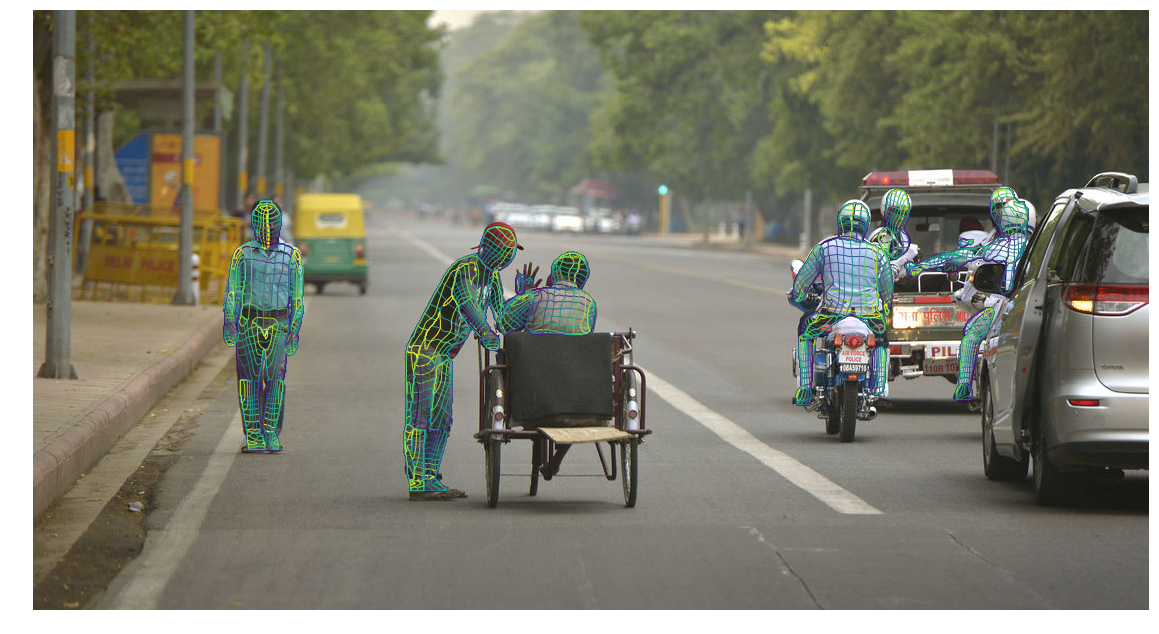

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

im  = cv2.imread(join(project_name, 'DensePoseData/demo_data/demo_im.jpg'))
IUV = cv2.imread(join(project_name, 'DensePoseData/infer_out/demo_im_IUV.png'))
INDS = cv2.imread(join(project_name, 'DensePoseData/infer_out/demo_im_INDS.png'),  0)

fig = plt.figure(figsize=[20, 20])
plt.imshow( im[:,:,::-1] )
plt.contour( IUV[:,:,1]/256.,10, linewidths = 1 )
plt.contour( IUV[:,:,2]/256.,10, linewidths = 1 )
plt.axis('off') ; plt.show()